In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
import numpy as np

### This notebook implement pre-trained ResNet50 feature extract and one-class-SVM classifier for COSMOP project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/images_notation_train_test.zip" -d "/content"

# Load dataset

In [ ]:
IMAGE_SIZE = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images_notation_train_test/train/positive",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images_notation_train_test/train/negative", 
    image_size=(IMAGE_SIZE,IMAGE_SIZE)

)


Found 1357 files belonging to 1 classes.
Found 2100 files belonging to 1 classes.


In [ ]:
test_posi_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images_notation_train_test/test/positive", 
    image_size=(IMAGE_SIZE,IMAGE_SIZE)

)

test_nega_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images_notation_train_test/test/negative", 
    image_size=(IMAGE_SIZE,IMAGE_SIZE)

)

Found 340 files belonging to 1 classes.
Found 526 files belonging to 1 classes.


##Load ResNet50 weights pre-trained on ImageNet

In [ ]:
base_model = ResNet50(
    weights="imagenet",  
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False) 

# Freeze the base_ model
base_model.trainable = False

base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

### Extract immigration features based on positive immigration training data

In [ ]:
feature_train = base_model.predict(train_ds)
X_train = feature_train.reshape(feature_train.shape[0], -1)

### The dimension of the extract features is 100352, this's too much, so dimension reduction need to be done before feeding to one-class-svm

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
pca = PCA(n_components=1024, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))

Explained variance percentage = 0.93


In [ ]:
# The new 1024 dimension features
X_train = pca.transform(X_train)

### Training one-class-svm with the features after dimension reduction

In [ ]:
from sklearn.svm import OneClassSVM

# OCSVM hyperparameters
nu = 0.08
gamma = 0.001

# Fit the One-Class SVM
clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
n_error_train = y_pred_train[y_pred_train == -1].size
n_true_train = y_pred_train[y_pred_train == 1].size

In [ ]:
# Check the recall on training positive data
print(f'{n_true_train} / {X_train.shape[0]}', f'Precision is {n_true_train/X_train.shape[0]}')

1030 / 1357 Precision is 0.759027266028003


In [ ]:
print(f'{n_error_train} / {X_train.shape[0]}')

327 / 1357


In [ ]:
# Check the classifier miss classify negative to positive ration
feature_valid = base_model.predict(validation_ds)
X_valid = feature_valid.reshape(feature_valid.shape[0], -1)
X_valid = pca.transform(X_valid)
y_pred_valid_val = clf.predict(X_valid)
n_error_val = y_pred_valid_val[y_pred_valid_val == 1].size
print(f'{n_error_val} / {X_valid.shape[0]}', f'Precision is {n_error_val/X_valid.shape[0]}')

2046 / 2100 Precision is 0.9742857142857143


In [ ]:
# Evaluate the model on positive test data
feature_test_posi = base_model.predict(test_posi_ds)
X_test_posi = feature_test_posi.reshape(feature_test_posi.shape[0], -1)
X_test_posi = pca.transform(X_test_posi)
y_pred_test_posi = clf.predict(X_test_posi)
n_true_val = y_pred_test_posi[y_pred_test_posi == 1].size
print(f'{n_true_val} / {X_test_posi.shape[0]}', f'Precision is {n_true_val/X_test_posi.shape[0]}')

254 / 340 Precision is 0.7470588235294118


In [ ]:
# Evaluate the model on negative test data through miss classification ratio
feature_test_nega = base_model.predict(test_nega_ds)
X_test_nega = feature_test_nega.reshape(feature_test_nega.shape[0], -1)
X_test_nega = pca.transform(X_test_nega)
y_pred_test_nega = clf.predict(X_test_nega)
n_error_val = y_pred_test_nega[y_pred_test_nega == 1].size
print(f'{n_error_val} / {X_test_nega.shape[0]}', f'Precision is {n_error_val/X_test_nega.shape[0]}')

513 / 526 Precision is 0.9752851711026616


### Display the confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def get_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix of OneClassSVM")
    plt.colorbar()

    classes = ["immigration", "non-immigration"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    correct_num = 0
    for k in range(cm.shape[0]):
        print(classes[k], "accuracy is: ", cm[k, k] / np.sum(cm[k, :]))
        correct_num += cm[k, k]

    print("Total accuracy is :", correct_num / np.sum(cm))

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

In [ ]:
cm = np.array([[254,86],[513,13]])
cm

array([[254,  86],
       [513,  13]])

immigration accuracy is:  0.7470588235294118
non-immigration accuracy is:  0.024714828897338403
Total accuracy is : 0.3083140877598152


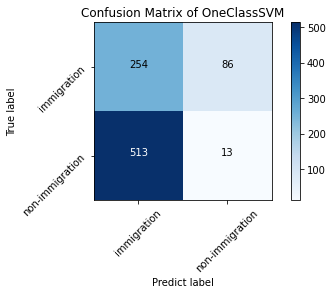

In [ ]:
get_confusion_matrix(cm)

In [ ]:
# precision of the classifier
254/(254+513)

0.33116036505867014

In [ ]:
# recall of the classifier
254/(254+86)

0.7470588235294118

In [ ]:
# accuracy of the classifier
(254+13)/866

0.3083140877598152